In [1]:
import numpy as np
# import cv2
import tifffile as tiff
from shapely.geometry import Polygon, mapping, shape, box
from skimage import io
from skimage.measure import label, regionprops
import matplotlib.pyplot as plt
# import json
from rasterio import features
import scanpy as sc
import pandas as pd
import geopandas as gpd

import pickle
import scipy

from ast import literal_eval

import seaborn as sns

from SGanalysis.SGobject import SGobject
from adjustText import adjust_text

import matplotlib
%matplotlib inline
# matplotlib.use('Qt5Agg')
# %matplotlib qt

# import matplotlib as mpl
matplotlib.rcParams['pdf.fonttype'] = 42

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial']

plt.rcParams['font.size'] = 6  # Set default font size for all text elements
plt.rcParams['axes.labelsize'] = 8  # Set font size for axis labels
plt.rcParams['xtick.labelsize'] = 6  # Set font size for x-axis tick labels
plt.rcParams['ytick.labelsize'] = 6  # Set font size for y-axis tick labels
plt.rcParams['legend.fontsize'] = 6  # Set font size for legend text

from sklearn.cluster import AgglomerativeClustering as AggCluster

%load_ext autoreload
%autoreload 2
%reload_ext autoreload

import sys
import os

# tools_path  = '/Users/grantkinsler/Documents/Penn/Research/SpatialBarcodes/SpatialBarcodes/analysis/tools/tools.py'
tools_path = '../helperScripts/tools.py'
# tools_path  = '/Users/grantkinsler/Documents/Penn/Research/SpatialBarcodes/analysis/tools/tools.py'

# /Users/grantkinsler/Documents/Penn/Research/SpatialBarcodes/analysis/tools/tools.py
sys.path.append(os.path.dirname(os.path.expanduser(tools_path)))
import tools as tools

In [2]:
## load data for the roi of interest    
roi_of_interest = 'roi_2'

# # load the sg_object
# with open(f'{roi_file_paths[roi_of_interest]["out_path"]}/sg_object_dilate10_20240718.pkl', 'rb') as f:
#     sg_obj = pickle.load(f)

# load the dataframes with the cell by gene matrices, clustered and unclustered
unclustered_df =  pd.read_csv(f'{tools.roi_file_paths[roi_of_interest]["out_path"]}/cell_by_gene_matrix_dilate10_20240718_withbarcodes_atleast3.csv')
clustered_df = pd.read_csv(f'{tools.roi_file_paths[roi_of_interest]["out_path"]}/cell_by_gene_matrix_dilate10_20240718_withbarcodes_clustering_10bcs_0.4thresh.csv')



In [3]:
# merge the clustered and unclustered dataframes
cols_to_keep = ['object_id','bc_cluster','bc_cluster_n_bcs','bc_cluster_found_bcs','bc_cluster_bc_names']
df = unclustered_df.merge(clustered_df[cols_to_keep],on='object_id',how='left')   

In [4]:
gene_cols = [col for col in df.columns if 'bc_' not in col and col not in ['cell_id','object_id','area','called_barcodes','n_called_barcodes','barcode_names','area','center_x','center_y','nucleus','nucleus_centroid','nucleus_dilated']]    


In [5]:
### Functions to calculate gene expression statistics by groupings

# calculate the average of each gene in each group (e.g. spatial location or clone )
def grouped_obs_mean(adata, group_key, layer=None, gene_symbols=None):
    if layer is not None:
        getX = lambda x: x.layers[layer]
    else:
        getX = lambda x: x.X
    if gene_symbols is not None:
        new_idx = adata.var[idx]
    else:
        new_idx = adata.var_names

    grouped = adata.obs.groupby(group_key)
    out = pd.DataFrame(
        np.zeros((adata.shape[1], len(grouped)), dtype=np.float64),
        columns=list(grouped.groups.keys()),
        index=adata.var_names
    )

    for group, idx in grouped.indices.items():
        X = getX(adata[idx])
        out[group] = np.ravel(X.mean(axis=0, dtype=np.float64)).tolist()

    return out

# calculate the difference between maximum and minimum for each group from grouped_obs_mean
def group_delta_mean(adata, group_key, layer=None, gene_symbols=None):
    mean = grouped_obs_mean(adata, group_key, layer=layer, gene_symbols=gene_symbols)
    delta = mean.max(axis=1) - mean.min(axis=1)
    return delta

# perform permutations on the group identities and return the distribution of deltas for each gene
def permuted_group_delta_means(adata,group_key,n_perms=100, layer=None, gene_symbols=None):
    
    perms = []
    for perm in range(n_perms):
        permuted_clusters = adata.copy()
        permuted_clusters.obs[group_key] = np.random.permutation(adata.obs[group_key].values)
        gene_by_bc_cluster_mean_perm = group_delta_mean(permuted_clusters,group_key)
        perms.append(gene_by_bc_cluster_mean_perm)

    return perms

# calculate the empirical p-values for each gene
def calculate_empirical_p_values(real_values,permuted_values):
    p_values = []
    for gene in real_values.index:
        p_values.append((np.sum(permuted_values[gene] >= real_values[gene])+1)/(len(permuted_values[gene])+1))
        
    return pd.Series(p_values,index=real_values.index)

# calculate the score for each gene, which is the ratio of the real value to the mean of the permuted values
def calculate_group_scores(real_values,permuted_values):
    return real_values/np.mean(permuted_values,axis=0)



In [6]:
# ring_annotated = pd.read_csv('../extractedData/in_vivo/ring_anotated_cell_by_gene.csv',index_col=0)
ring_annotated = pd.read_csv('../extractedData/in_vivo/cell_by_gene_with_rings.csv',index_col=0)
# ring_annotated_100 = pd.read_csv('/Users/grantkinsler/RajLab Dropbox/Grant Kinsler/SpatialBarcodes/ImagingData/2024-05-21_mouseexp_expression/projects/roi_2/processedData/erosion_analysis/num_iterations_100/ring_anotated_cell_by_gene_100.csv',index_col=0)
# ring_annotated_200 = pd.read_csv('/Users/grantkinsler/RajLab Dropbox/Grant Kinsler/SpatialBarcodes/ImagingData/2024-05-21_mouseexp_expression/projects/roi_2/processedData/erosion_analysis/num_iterations_200/ring_anotated_cell_by_gene.csv',index_col=0)

In [7]:
ring_annotated

,object_id,AKT1,AXL,BGN,BIRC3,BIRC5,BMP2,BMP4,CALD1,CAPG,...,called_barcodes,n_called_barcodes,barcode_names,nucleus,nucleus_dilated,nucleus_centroid,center_x,center_y,area,Ring
0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,[],0,NaN,"POLYGON ((23727 1097, 23741 1098, 23776 1120, ...",POLYGON ((23723.19250194746 1087.7532190152529...,POINT (23747.879605737267 1155.8892298393657),23747.879606,1155.889230,12083.909039,NaN
1,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,[],0,NaN,"POLYGON ((23811 1166, 23822 1166, 23829 1169, ...",POLYGON ((23807.28609323646 1156.7152330911474...,POINT (23806.27792651224 1229.8663523842781),23806.277927,1229.866352,12327.850827,NaN
2,3,0.0,0.0,0.0,0.0,1.0,0.0,0.0,3.0,3.0,...,['bc_060'],1,bc_060,"POLYGON ((19383 1449, 19398 1451, 19403 1456, ...","POLYGON ((19378.527864045 1440.055728090001, 1...",POINT (19365.23205956225 1485.2640383925368),19365.232060,1485.264038,6440.407723,1.0
3,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,[],0,NaN,"POLYGON ((19107 1506, 19137 1507, 19157 1511, ...",POLYGON ((19091.029238372354 1530.598230956909...,POINT (19129.7205683893 1524.7188219417321),19129.720568,1524.718822,4279.403177,1.0
4,7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,[],0,NaN,"POLYGON ((15238 1549, 15252 1549, 15252 1556, ...",POLYGON ((15236.759652654107 1539.077221232863...,POINT (15196.782899770467 1575.0830145371078),15196.782900,1575.083015,5458.813969,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67197,67193,2.0,0.0,6.0,0.0,1.0,0.0,0.0,9.0,14.0,...,[],0,NaN,"POLYGON ((37771 46466, 37777 46470, 37785 4648...",POLYGON ((37765.537322194534 46457.62389403161...,POINT (37783.46201006832 46544.91209996404),37783.462010,46544.912100,13678.319345,1.0
67198,67199,0.0,0.0,0.0,0.0,1.0,0.0,0.0,7.0,10.0,...,[],0,NaN,"POLYGON ((38215 46546, 38237 46547, 38260 4655...",POLYGON ((38212.44107439684 46536.332947721385...,POINT (38208.40403415784 46576.99602473498),38208.404034,46576.996025,9246.990769,1.0
67199,67200,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,5.0,...,[],0,NaN,"POLYGON ((38366 46565, 38403 46566, 38439 4658...","POLYGON ((38364.1571146495 46555.171278130656,...",POINT (38384.67654884075 46598.133528126185),38384.676549,46598.133528,10661.078562,0.0
67200,67201,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,...,[],0,NaN,"POLYGON ((38105 46579, 38137 46586, 38139 4659...","POLYGON ((38099.85504244573 46570.42507074287,...",POINT (38113.04224095191 46613.43592794579),38113.042241,46613.435928,8041.815355,0.0


In [8]:
# df.sort_values('object_id',inplace=True)
# ring_annotated.sort_values('object_id',inplace=True)

df = df.merge(ring_annotated[['object_id','Ring']],on='object_id',how='left')

In [9]:
unclustered_df

,object_id,AKT1,AXL,BGN,BIRC3,BIRC5,BMP2,BMP4,CALD1,CAPG,...,cell_id,called_barcodes,n_called_barcodes,barcode_names,nucleus,nucleus_dilated,nucleus_centroid,center_x,center_y,area
0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1,[],0,NaN,"POLYGON ((23727 1097, 23741 1098, 23776 1120, ...",POLYGON ((23723.19250194746 1087.7532190152529...,POINT (23747.879605737267 1155.8892298393657),23747.879606,1155.889230,12083.909039
1,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,2,[],0,NaN,"POLYGON ((23811 1166, 23822 1166, 23829 1169, ...",POLYGON ((23807.28609323646 1156.7152330911474...,POINT (23806.27792651224 1229.8663523842781),23806.277927,1229.866352,12327.850827
2,3,0.0,0.0,0.0,0.0,1.0,0.0,0.0,3.0,3.0,...,3,['bc_060'],1,bc_060,"POLYGON ((19383 1449, 19398 1451, 19403 1456, ...","POLYGON ((19378.527864045 1440.055728090001, 1...",POINT (19365.23205956225 1485.2640383925368),19365.232060,1485.264038,6440.407723
3,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,4,[],0,NaN,"POLYGON ((19107 1506, 19137 1507, 19157 1511, ...",POLYGON ((19091.029238372354 1530.598230956909...,POINT (19129.7205683893 1524.7188219417321),19129.720568,1524.718822,4279.403177
4,7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,7,[],0,NaN,"POLYGON ((15238 1549, 15252 1549, 15252 1556, ...",POLYGON ((15236.759652654107 1539.077221232863...,POINT (15196.782899770467 1575.0830145371078),15196.782900,1575.083015,5458.813969
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67197,67193,2.0,0.0,6.0,0.0,1.0,0.0,0.0,9.0,14.0,...,67193,[],0,NaN,"POLYGON ((37771 46466, 37777 46470, 37785 4648...",POLYGON ((37765.537322194534 46457.62389403161...,POINT (37783.46201006832 46544.91209996404),37783.462010,46544.912100,13678.319345
67198,67199,0.0,0.0,0.0,0.0,1.0,0.0,0.0,7.0,10.0,...,67199,[],0,NaN,"POLYGON ((38215 46546, 38237 46547, 38260 4655...",POLYGON ((38212.44107439684 46536.332947721385...,POINT (38208.40403415784 46576.99602473498),38208.404034,46576.996025,9246.990769
67199,67200,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,5.0,...,67200,[],0,NaN,"POLYGON ((38366 46565, 38403 46566, 38439 4658...","POLYGON ((38364.1571146495 46555.171278130656,...",POINT (38384.67654884075 46598.133528126185),38384.676549,46598.133528,10661.078562
67200,67201,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,...,67201,[],0,NaN,"POLYGON ((38105 46579, 38137 46586, 38139 4659...","POLYGON ((38099.85504244573 46570.42507074287,...",POINT (38113.04224095191 46613.43592794579),38113.042241,46613.435928,8041.815355


In [10]:
ring_annotated

,object_id,AKT1,AXL,BGN,BIRC3,BIRC5,BMP2,BMP4,CALD1,CAPG,...,called_barcodes,n_called_barcodes,barcode_names,nucleus,nucleus_dilated,nucleus_centroid,center_x,center_y,area,Ring
0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,[],0,NaN,"POLYGON ((23727 1097, 23741 1098, 23776 1120, ...",POLYGON ((23723.19250194746 1087.7532190152529...,POINT (23747.879605737267 1155.8892298393657),23747.879606,1155.889230,12083.909039,NaN
1,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,[],0,NaN,"POLYGON ((23811 1166, 23822 1166, 23829 1169, ...",POLYGON ((23807.28609323646 1156.7152330911474...,POINT (23806.27792651224 1229.8663523842781),23806.277927,1229.866352,12327.850827,NaN
2,3,0.0,0.0,0.0,0.0,1.0,0.0,0.0,3.0,3.0,...,['bc_060'],1,bc_060,"POLYGON ((19383 1449, 19398 1451, 19403 1456, ...","POLYGON ((19378.527864045 1440.055728090001, 1...",POINT (19365.23205956225 1485.2640383925368),19365.232060,1485.264038,6440.407723,1.0
3,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,[],0,NaN,"POLYGON ((19107 1506, 19137 1507, 19157 1511, ...",POLYGON ((19091.029238372354 1530.598230956909...,POINT (19129.7205683893 1524.7188219417321),19129.720568,1524.718822,4279.403177,1.0
4,7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,[],0,NaN,"POLYGON ((15238 1549, 15252 1549, 15252 1556, ...",POLYGON ((15236.759652654107 1539.077221232863...,POINT (15196.782899770467 1575.0830145371078),15196.782900,1575.083015,5458.813969,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67197,67193,2.0,0.0,6.0,0.0,1.0,0.0,0.0,9.0,14.0,...,[],0,NaN,"POLYGON ((37771 46466, 37777 46470, 37785 4648...",POLYGON ((37765.537322194534 46457.62389403161...,POINT (37783.46201006832 46544.91209996404),37783.462010,46544.912100,13678.319345,1.0
67198,67199,0.0,0.0,0.0,0.0,1.0,0.0,0.0,7.0,10.0,...,[],0,NaN,"POLYGON ((38215 46546, 38237 46547, 38260 4655...",POLYGON ((38212.44107439684 46536.332947721385...,POINT (38208.40403415784 46576.99602473498),38208.404034,46576.996025,9246.990769,1.0
67199,67200,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,5.0,...,[],0,NaN,"POLYGON ((38366 46565, 38403 46566, 38439 4658...","POLYGON ((38364.1571146495 46555.171278130656,...",POINT (38384.67654884075 46598.133528126185),38384.676549,46598.133528,10661.078562,0.0
67200,67201,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,...,[],0,NaN,"POLYGON ((38105 46579, 38137 46586, 38139 4659...","POLYGON ((38099.85504244573 46570.42507074287,...",POINT (38113.04224095191 46613.43592794579),38113.042241,46613.435928,8041.815355,0.0


In [11]:
df

,object_id,AKT1,AXL,BGN,BIRC3,BIRC5,BMP2,BMP4,CALD1,CAPG,...,nucleus_dilated,nucleus_centroid,center_x,center_y,area,bc_cluster,bc_cluster_n_bcs,bc_cluster_found_bcs,bc_cluster_bc_names,Ring
0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,POLYGON ((23723.19250194746 1087.7532190152529...,POINT (23747.879605737267 1155.8892298393657),23747.879606,1155.889230,12083.909039,NaN,NaN,NaN,NaN,NaN
1,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,POLYGON ((23807.28609323646 1156.7152330911474...,POINT (23806.27792651224 1229.8663523842781),23806.277927,1229.866352,12327.850827,NaN,NaN,NaN,NaN,NaN
2,3,0.0,0.0,0.0,0.0,1.0,0.0,0.0,3.0,3.0,...,"POLYGON ((19378.527864045 1440.055728090001, 1...",POINT (19365.23205956225 1485.2640383925368),19365.232060,1485.264038,6440.407723,NaN,NaN,NaN,NaN,1.0
3,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,POLYGON ((19091.029238372354 1530.598230956909...,POINT (19129.7205683893 1524.7188219417321),19129.720568,1524.718822,4279.403177,NaN,NaN,NaN,NaN,1.0
4,7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,POLYGON ((15236.759652654107 1539.077221232863...,POINT (15196.782899770467 1575.0830145371078),15196.782900,1575.083015,5458.813969,NaN,NaN,NaN,NaN,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67197,67193,2.0,0.0,6.0,0.0,1.0,0.0,0.0,9.0,14.0,...,POLYGON ((37765.537322194534 46457.62389403161...,POINT (37783.46201006832 46544.91209996404),37783.462010,46544.912100,13678.319345,NaN,NaN,NaN,NaN,1.0
67198,67199,0.0,0.0,0.0,0.0,1.0,0.0,0.0,7.0,10.0,...,POLYGON ((38212.44107439684 46536.332947721385...,POINT (38208.40403415784 46576.99602473498),38208.404034,46576.996025,9246.990769,NaN,NaN,NaN,NaN,1.0
67199,67200,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,5.0,...,"POLYGON ((38364.1571146495 46555.171278130656,...",POINT (38384.67654884075 46598.133528126185),38384.676549,46598.133528,10661.078562,NaN,NaN,NaN,NaN,0.0
67200,67201,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,...,"POLYGON ((38099.85504244573 46570.42507074287,...",POINT (38113.04224095191 46613.43592794579),38113.042241,46613.435928,8041.815355,NaN,NaN,NaN,NaN,0.0


<AxesSubplot: xlabel='center_x', ylabel='center_y'>

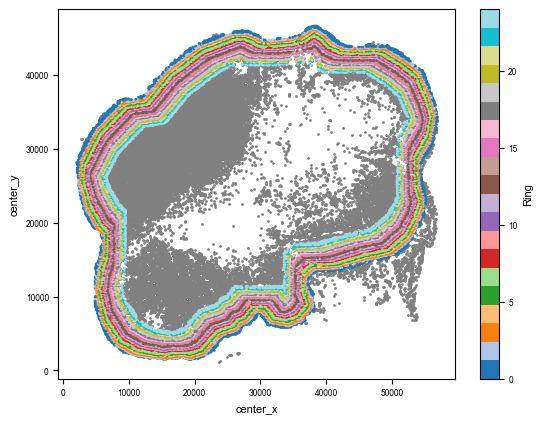

In [12]:
plt.figure()
ax = plt.gca()
df.plot.scatter(x='center_x',y='center_y',c='gray',s=1,ax=ax)


ring_annotated.plot.scatter(x='center_x',y='center_y',c='Ring',cmap='tab20',s=1,ax=ax)

In [13]:
## we can calculate the space scores only for barcoded cells
df_barcoded = df[df['bc_cluster'].notnull()]

for ring_partition,n_partitions in zip([ring_annotated],[25]):

    ring_partition = ring_partition[ring_partition['cell_id'].isin(df_barcoded['object_id'])]

    adata_genes_ring = sc.AnnData(ring_partition[[col for col in ring_partition.columns if col in gene_cols]])

    # assign erosion ring to each cell in obs according to the ring_annoted file
    adata_genes_ring.obs['erosion_ring'] = ring_partition['Ring'].values

        # calculate the statistics for clones
    real_delta_ring  = group_delta_mean(adata_genes_ring,'erosion_ring')
    perm_deltas_ring = permuted_group_delta_means(adata_genes_ring,'erosion_ring',n_perms=12000)
    # perm_deltas_ring = permuted_group_delta_means(adata_genes_ring,'erosion_ring',n_perms=1000)

    # calculate the scores and p-values for the clones
    scores_ring = calculate_group_scores(real_delta_ring,pd.DataFrame(perm_deltas_ring))
    p_vals_ring = calculate_empirical_p_values(real_delta_ring,pd.DataFrame(perm_deltas_ring))


    space_score_df = pd.DataFrame({'gene':scores_ring.index,'score':scores_ring,'p_val':p_vals_ring})

    space_score_df.to_csv(f'../extractedData/in_vivo/space_scores_{n_partitions}rings_barcoded.csv',index=False)

/var/folders/x6/q0wb9df97nj1wnk5c4t0k7840000gn/T/ipykernel_40198/461580758.py:8: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata_genes_ring = sc.AnnData(ring_partition[[col for col in ring_partition.columns if col in gene_cols]])
/Users/grantkinsler/opt/miniconda3/envs/spatialgenomics-env2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [14]:
scores_ring.sort_values(ascending=False).head(10)

VEGFA     6.660215
MITF      6.618669
MYBL2     6.134306
ESPN      6.000168
IGFBP7    5.960750
SPARC     5.613012
COL9A3    5.356804
LOXL2     5.297234
BIRC5     5.217123
CTNNB1    5.193245
dtype: float64

In [15]:
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

VEGFA 341.46000000000004
MITF 37.94


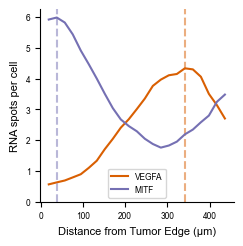

In [16]:
plt.figure(figsize=(2.5,2.5))
means_ring = grouped_obs_mean(adata_genes_ring,'erosion_ring')

# genes_to_show = ['VEGFA','MITF','SFRP1','SPARC']
genes_to_show = ['VEGFA','MITF']

window_size =3

gene_colors = {
                # 'VEGFA':'#5e3c99',
               'VEGFA':'#d95f02',
               
            #    'MITF':'#e66101',
               'MITF':'#7570b3',
               
               }
for gene in genes_to_show:
    # plt.plot(means_ring.loc[gene],label=gene,color=colors[gene])
    # plt.plot(moving_average((means_ring.loc[gene]/np.sum(means_ring.loc[gene])).values,3),label=gene,color=colors[genes_to_show.index(gene)])

    width = 18.97
    x_space = [x*width for x in range(len(means_ring.loc[gene]))]


    plt.plot(moving_average(x_space,window_size),moving_average((means_ring.loc[gene]).values,window_size),label=gene,color=gene_colors[gene])

    max_idx = np.argmax(moving_average((means_ring.loc[gene]).values,window_size))
    plt.axvline(x=moving_average(x_space,window_size)[max_idx],color=gene_colors[gene],linestyle='--',alpha=0.5)
    
    print(gene,moving_average(x_space,window_size)[max_idx])

    

plt.legend()
plt.xlabel('Distance from Tumor Edge (µm)')
plt.ylabel('RNA spots per cell')

plt.yticks(range(7),range(7))
# plt.xticks(ran)



# remove top and right spines
sns.despine()

plt.savefig('../graphs/genes_vs_distance_25rings_barcode.pdf',transparent=True,bbox_inches='tight')